## Similarity-based RUL Prediction

In [ ]:
import pandas as pd
import numpy as np

import random
random.seed = 42
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time
import os
#os.chdir("C:/Data/aircraft/")

from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve ,mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight
from prettytable import PrettyTable

from statsmodels.tsa.holtwinters import ExponentialSmoothing , HoltWintersResults
from scipy.signal import savgol_filter

In [ ]:
dependent_var = ['RUL']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

def prepare_data():
    
    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)

    y_test = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_test["UnitNumber"] = y_test.index + 1
    
    return df_train, df_test, y_test

In [ ]:
df_train, df_test, y_test = prepare_data()
df_train.shape, df_test.shape, y_test.shape

((20631, 27), (13096, 26), (100, 2))

In [ ]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))

df_train[feats] = sc.fit_transform(df_train[feats])
df_test[feats] = sc.transform(df_test[feats])

In [ ]:
df_train.head()

UnitNumber  Cycle    OpSet1  ...  SensorMeasure20  SensorMeasure21  RUL
0           1      1  0.459770  ...         0.713178         0.724662  191
1           1      2  0.609195  ...         0.666667         0.731014  190
2           1      3  0.252874  ...         0.627907         0.621375  189
3           1      4  0.540230  ...         0.573643         0.662386  188
4           1      5  0.390805  ...         0.589147         0.704502  187

[5 rows x 27 columns]

In [ ]:
df_test.head()

UnitNumber  Cycle  ...  SensorMeasure20  SensorMeasure21
0           1      1  ...         0.558140         0.661834
1           1      2  ...         0.682171         0.686827
2           1      3  ...         0.728682         0.721348
3           1      4  ...         0.666667         0.662110
4           1      5  ...         0.658915         0.716377

[5 rows x 26 columns]

### Selecting features using Trendability

\begin{equation*}
Trendability \ (x) = | \frac{1}{M} \sum_{j=1}^{M} \ corr(x_j, t_j) |
\end{equation*}

Finding the average correlation of features with time.

Where j is unit.

In [ ]:
def trendability(col):
    
    trend_vals = []
    
    for i in df_train.UnitNumber.unique():
        dff = df_train[df_train.UnitNumber == i]
        trend_vals.append(dff[['Cycle', col]].corr().iloc[0][1])
        
    return np.abs(np.mean(trend_vals))

In [ ]:
trend_df = pd.DataFrame(columns = ['feature', 'trendability_val'])

for col in feats:
    trend_df = trend_df.append({'feature': col, 'trendability_val': trendability(col)}, ignore_index = True)

In [ ]:
trend_df = trend_df.sort_values(by = 'trendability_val', ascending = False)
trend_df.head()

feature  trendability_val
13  SensorMeasure11          0.810601
14  SensorMeasure12          0.789662
6    SensorMeasure4          0.781614
9    SensorMeasure7          0.761514
17  SensorMeasure15          0.724844

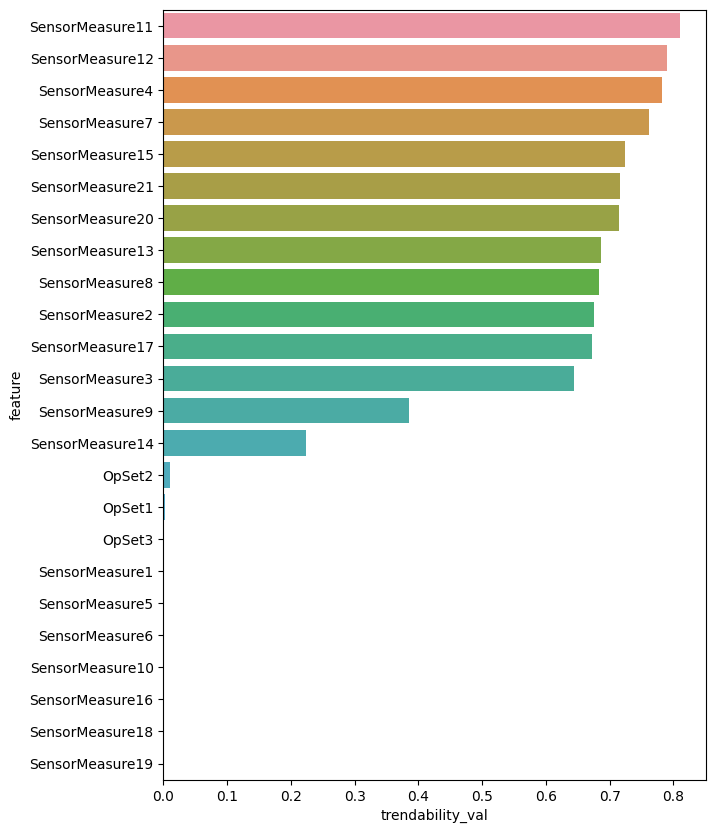

In [ ]:
fig, ax = plt.subplots(figsize = (7,10))

sns.barplot(y = trend_df.feature, x = trend_df.trendability_val)

Selecting features having trendability higher than 0.2

In [ ]:
feats = trend_df.feature[trend_df.trendability_val > 0.2]
feats

13    SensorMeasure11
14    SensorMeasure12
6      SensorMeasure4
9      SensorMeasure7
17    SensorMeasure15
23    SensorMeasure21
22    SensorMeasure20
15    SensorMeasure13
10     SensorMeasure8
4      SensorMeasure2
19    SensorMeasure17
5      SensorMeasure3
11     SensorMeasure9
16    SensorMeasure14
Name: feature, dtype: object

In [ ]:
len(feats)

14

### Creating a Linear Degradation model to fuse these features

Let's assume health condition of a unit is degrading linearly which can be achieved by rescaling RUL having 1-0 scale

In [ ]:
df_train['HI'] = df_train.groupby('UnitNumber').RUL.transform(lambda x: minmax_scale(x))

Visualizing health indicators of 1-30 units

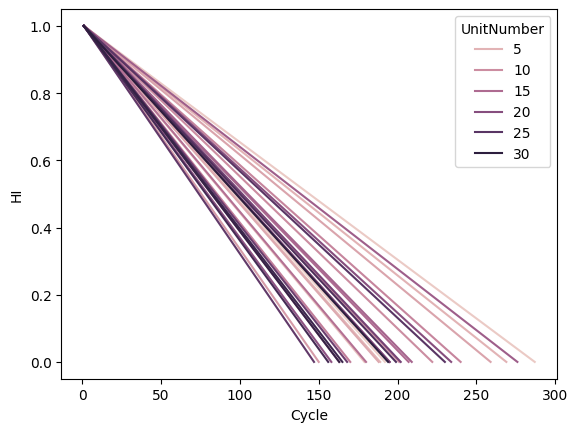

In [ ]:
sns.lineplot(data= df_train[df_train.UnitNumber < 31], x = 'Cycle', y = 'HI', hue= 'UnitNumber')

### Fiting a linear regression model of health condition with most trended features.

In [ ]:
model = LinearRegression()

In [ ]:
X = df_train[feats]
y = df_train.HI

X.shape, y.shape

((20631, 14), (20631,))

In [ ]:
model.fit(X,y)

model.score(X,y)

0.6520059883900058

In [ ]:
model.coef_

array([-0.26884914,  0.24180177, -0.20064758,  0.18905397, -0.12967532,
        0.13174699,  0.13877304, -0.0241087 ,  0.01229191, -0.08003577,
       -0.10509745, -0.09005357, -0.4145927 , -0.27325302])

In [ ]:
len(model.coef_)

14

In [ ]:
model.intercept_

0.6333546734289224

### Constructing a new health indicator by multiplying model coefficient with features

In [ ]:
df_train['HI_final'] = df_train[feats].dot(model.coef_)
df_train.HI_final.head()

0    0.087893
1    0.077465
2    0.122410
3    0.200864
4    0.071672
Name: HI_final, dtype: float64

Let's visualize final Health Indicators for 1-30 units

Text(0, 0.5, 'Health Indicator')

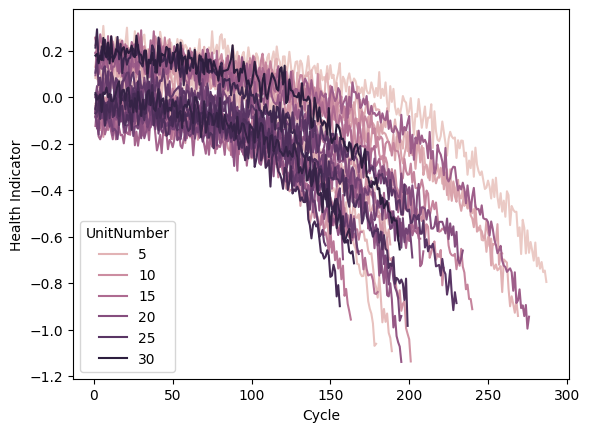

In [ ]:
sns.lineplot(data= df_train[df_train.UnitNumber < 31], x = 'Cycle', y = 'HI_final', hue= 'UnitNumber')
plt.ylabel('Health Indicator')

Smoothing the final health indicator to reduce noise.

In [ ]:
# exponential smoothing
exp_smooth =ExponentialSmoothing(df_train.HI_final[df_train.UnitNumber == 1],trend='add')
exp_smooth.fit();
Holt=HoltWintersResults(exp_smooth,exp_smooth.params)
y_exp=Holt.predict(0,len(df_train.HI_final[df_train.UnitNumber == 1])-1)

In [ ]:
# find odd window length for filtering
percent_n_smaple = 0.15
temp_window = int(len(df_train.HI_final[df_train.UnitNumber == 1])*percent_n_smaple)
if temp_window %2 ==0:
    window = temp_window-1
else:
    window= temp_window
    
# apply savgol_filter to the signal
y_filter = savgol_filter(df_train.HI_final[df_train.UnitNumber == 1], window_length=window,polyorder=3)

In [ ]:
window = 5

In [ ]:
df_train_HI = df_train.groupby('UnitNumber')['HI_final'].rolling(window = window).mean()
df_train_HI = df_train_HI.reset_index()
#df_train_HI.dropna(inplace = True)
df_train_HI.drop(['level_1'], axis = 1, inplace = True)
df_train_HI['cycle'] = df_train_HI.groupby('UnitNumber').cumcount()+1
df_train_HI.head()

UnitNumber  HI_final  cycle
0           1       NaN      1
1           1       NaN      2
2           1       NaN      3
3           1       NaN      4
4           1  0.112061      5

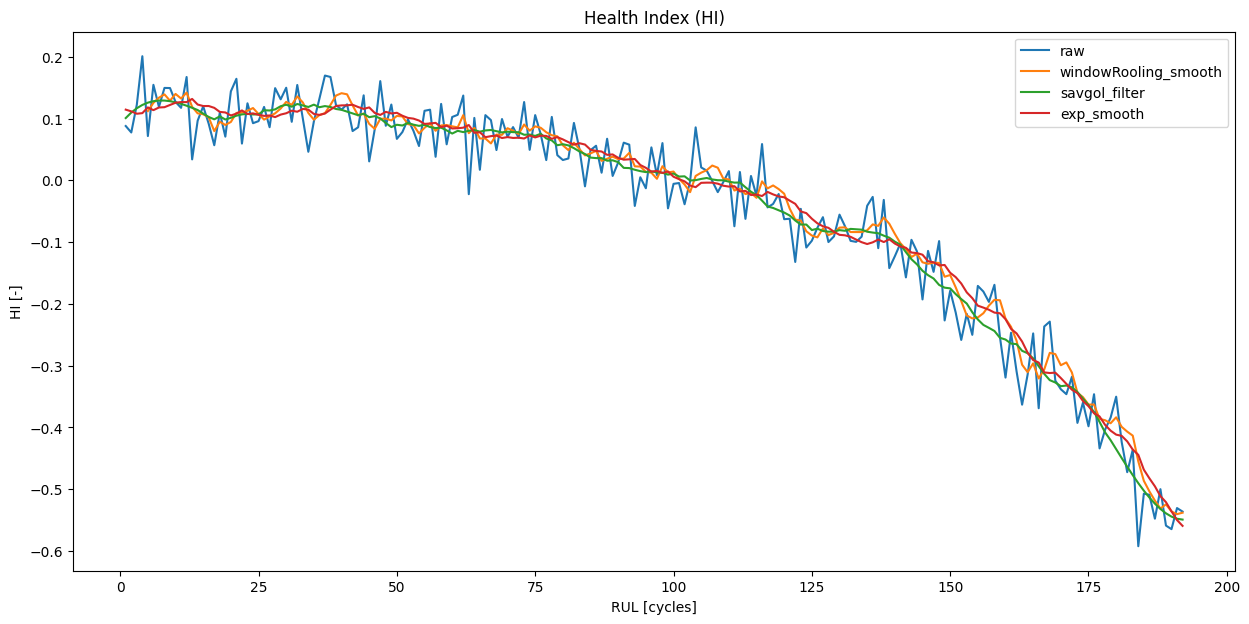

In [ ]:
# plot fused HI signal with the smoothed signals

fig=plt.figure(figsize=(15,7))
plt.plot(df_train.Cycle[df_train.UnitNumber == 1],df_train.HI_final[df_train.UnitNumber == 1],label='raw')
plt.plot(df_train.Cycle[df_train.UnitNumber == 1],df_train_HI.HI_final[df_train_HI.UnitNumber == 1],label='windowRooling_smooth')
plt.plot(df_train.Cycle[df_train.UnitNumber == 1],y_filter,label='savgol_filter')
plt.plot(df_train.Cycle[df_train.UnitNumber == 1],y_exp ,label='exp_smooth')
plt.title('Health Index (HI)')
plt.xlabel('RUL [cycles]')
plt.ylabel('HI [-]')
plt.legend();


Visualizing health indicators of all units and their failures

In [ ]:
df_train_HI = df_train.groupby('UnitNumber')['HI_final'].rolling(window = window).mean()
df_train_HI = df_train_HI.reset_index()
df_train_HI.dropna(inplace = True)
df_train_HI.drop(['level_1'], axis = 1, inplace = True)
df_train_HI['cycle'] = df_train_HI.groupby('UnitNumber').cumcount()+1
df_train_HI.head()

UnitNumber  HI_final  cycle
4           1  0.112061      1
5           1  0.125402      2
6           1  0.133693      3
7           1  0.139125      4
8           1  0.128823      5

Text(0, 0.5, 'Health Indicator')

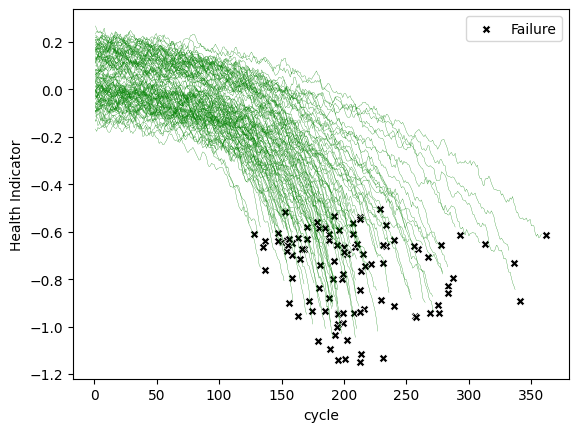

In [ ]:
for i in range(1,101):
    sns.lineplot(data= df_train_HI[df_train_HI.UnitNumber == i], x = 'cycle', y = 'HI_final', color = 'green', lw = 0.2)

sns.scatterplot(data = df_train[df_train.HI == 0], x = 'Cycle', y = 'HI_final', label = 'Failure', 
                marker = 'X', color = 'black')
plt.ylabel('Health Indicator')

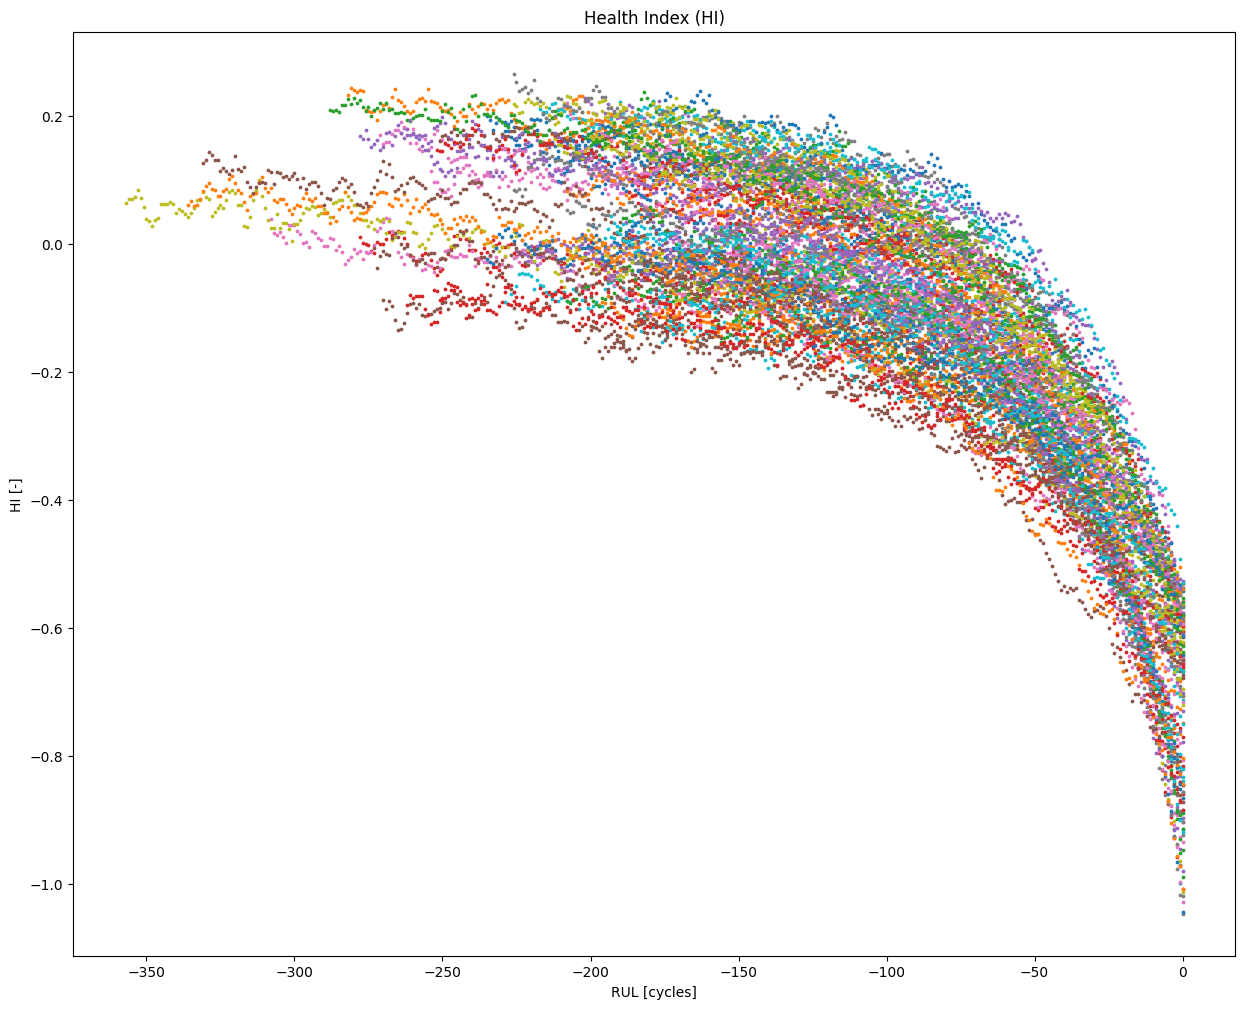

In [ ]:
# plot HI for all engines 
fig=plt.figure(figsize=(15,12))
for engine_num in df_train_HI.UnitNumber.unique():
    y = df_train_HI.HI_final[df_train_HI.UnitNumber == engine_num]
    x = -1*df_train.RUL[df_train.UnitNumber == engine_num]
    plt.scatter(x,y,label=engine_num,s=3)
#     plt.scatter(RUL_engine,HI_pred_log,label='Logistic')
    plt.title('Health Index (HI)')
    plt.xlabel('RUL [cycles]')
    plt.ylabel('HI [-]')
#     plt.legend();



### Fitting a second order polynomial function on these health indicators


$$ y = \theta_0 + \theta_1  x + \theta_2  x^2 $$

where y is a health indicator and x is a cycle

In [ ]:
params_df = pd.DataFrame(columns = ['UnitNumber', 'theta_2', 'theta_1', 'theta_0'])

for i in range(1,101):
    
    y = df_train_HI.HI_final[df_train_HI.UnitNumber == i]
    cycle = df_train_HI.cycle[df_train_HI.UnitNumber == i]

    theta_2, theta_1, theta_0 = np.polyfit(cycle, y, 2)
    
    params_df = params_df.append({'UnitNumber':i, 'theta_0': theta_0, 'theta_1': theta_1, 'theta_2': theta_2},
                                         ignore_index = True)

In [ ]:
params_df.head()

UnitNumber   theta_2   theta_1   theta_0
0         1.0 -0.000026  0.001935  0.081240
1         2.0 -0.000018  0.002209  0.156074
2         3.0 -0.000054  0.004785  0.046752
3         4.0 -0.000049  0.005086 -0.053809
4         5.0 -0.000022  0.002535  0.096549

Visualizing for unit 1

In [ ]:
HI = df_train_HI.HI_final[df_train_HI.UnitNumber == 1]
cycle = df_train_HI.cycle[df_train_HI.UnitNumber == 1]

theta_0 = params_df.theta_0[params_df.UnitNumber == 1].values
theta_1 = params_df.theta_1[params_df.UnitNumber == 1].values
theta_2 = params_df.theta_2[params_df.UnitNumber == 1].values

HI_fit = theta_0 + theta_1*cycle + theta_2*cycle*cycle

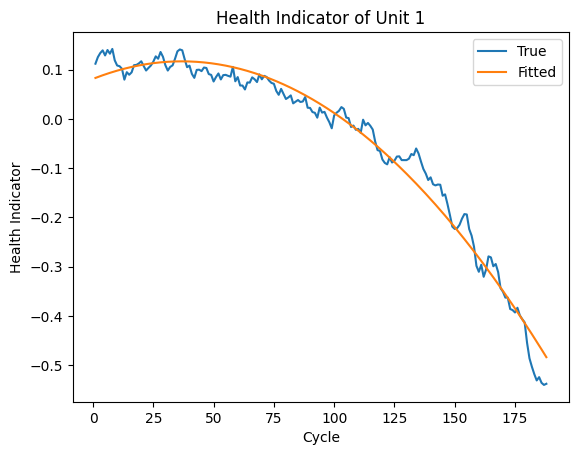

In [ ]:
plt.plot(cycle,HI, label = 'True')
plt.plot(cycle,HI_fit, label = 'Fitted')
plt.ylabel('Health Indicator')
plt.xlabel('Cycle')
plt.legend()
plt.title('Health Indicator of Unit 1');

Visualzing for all units

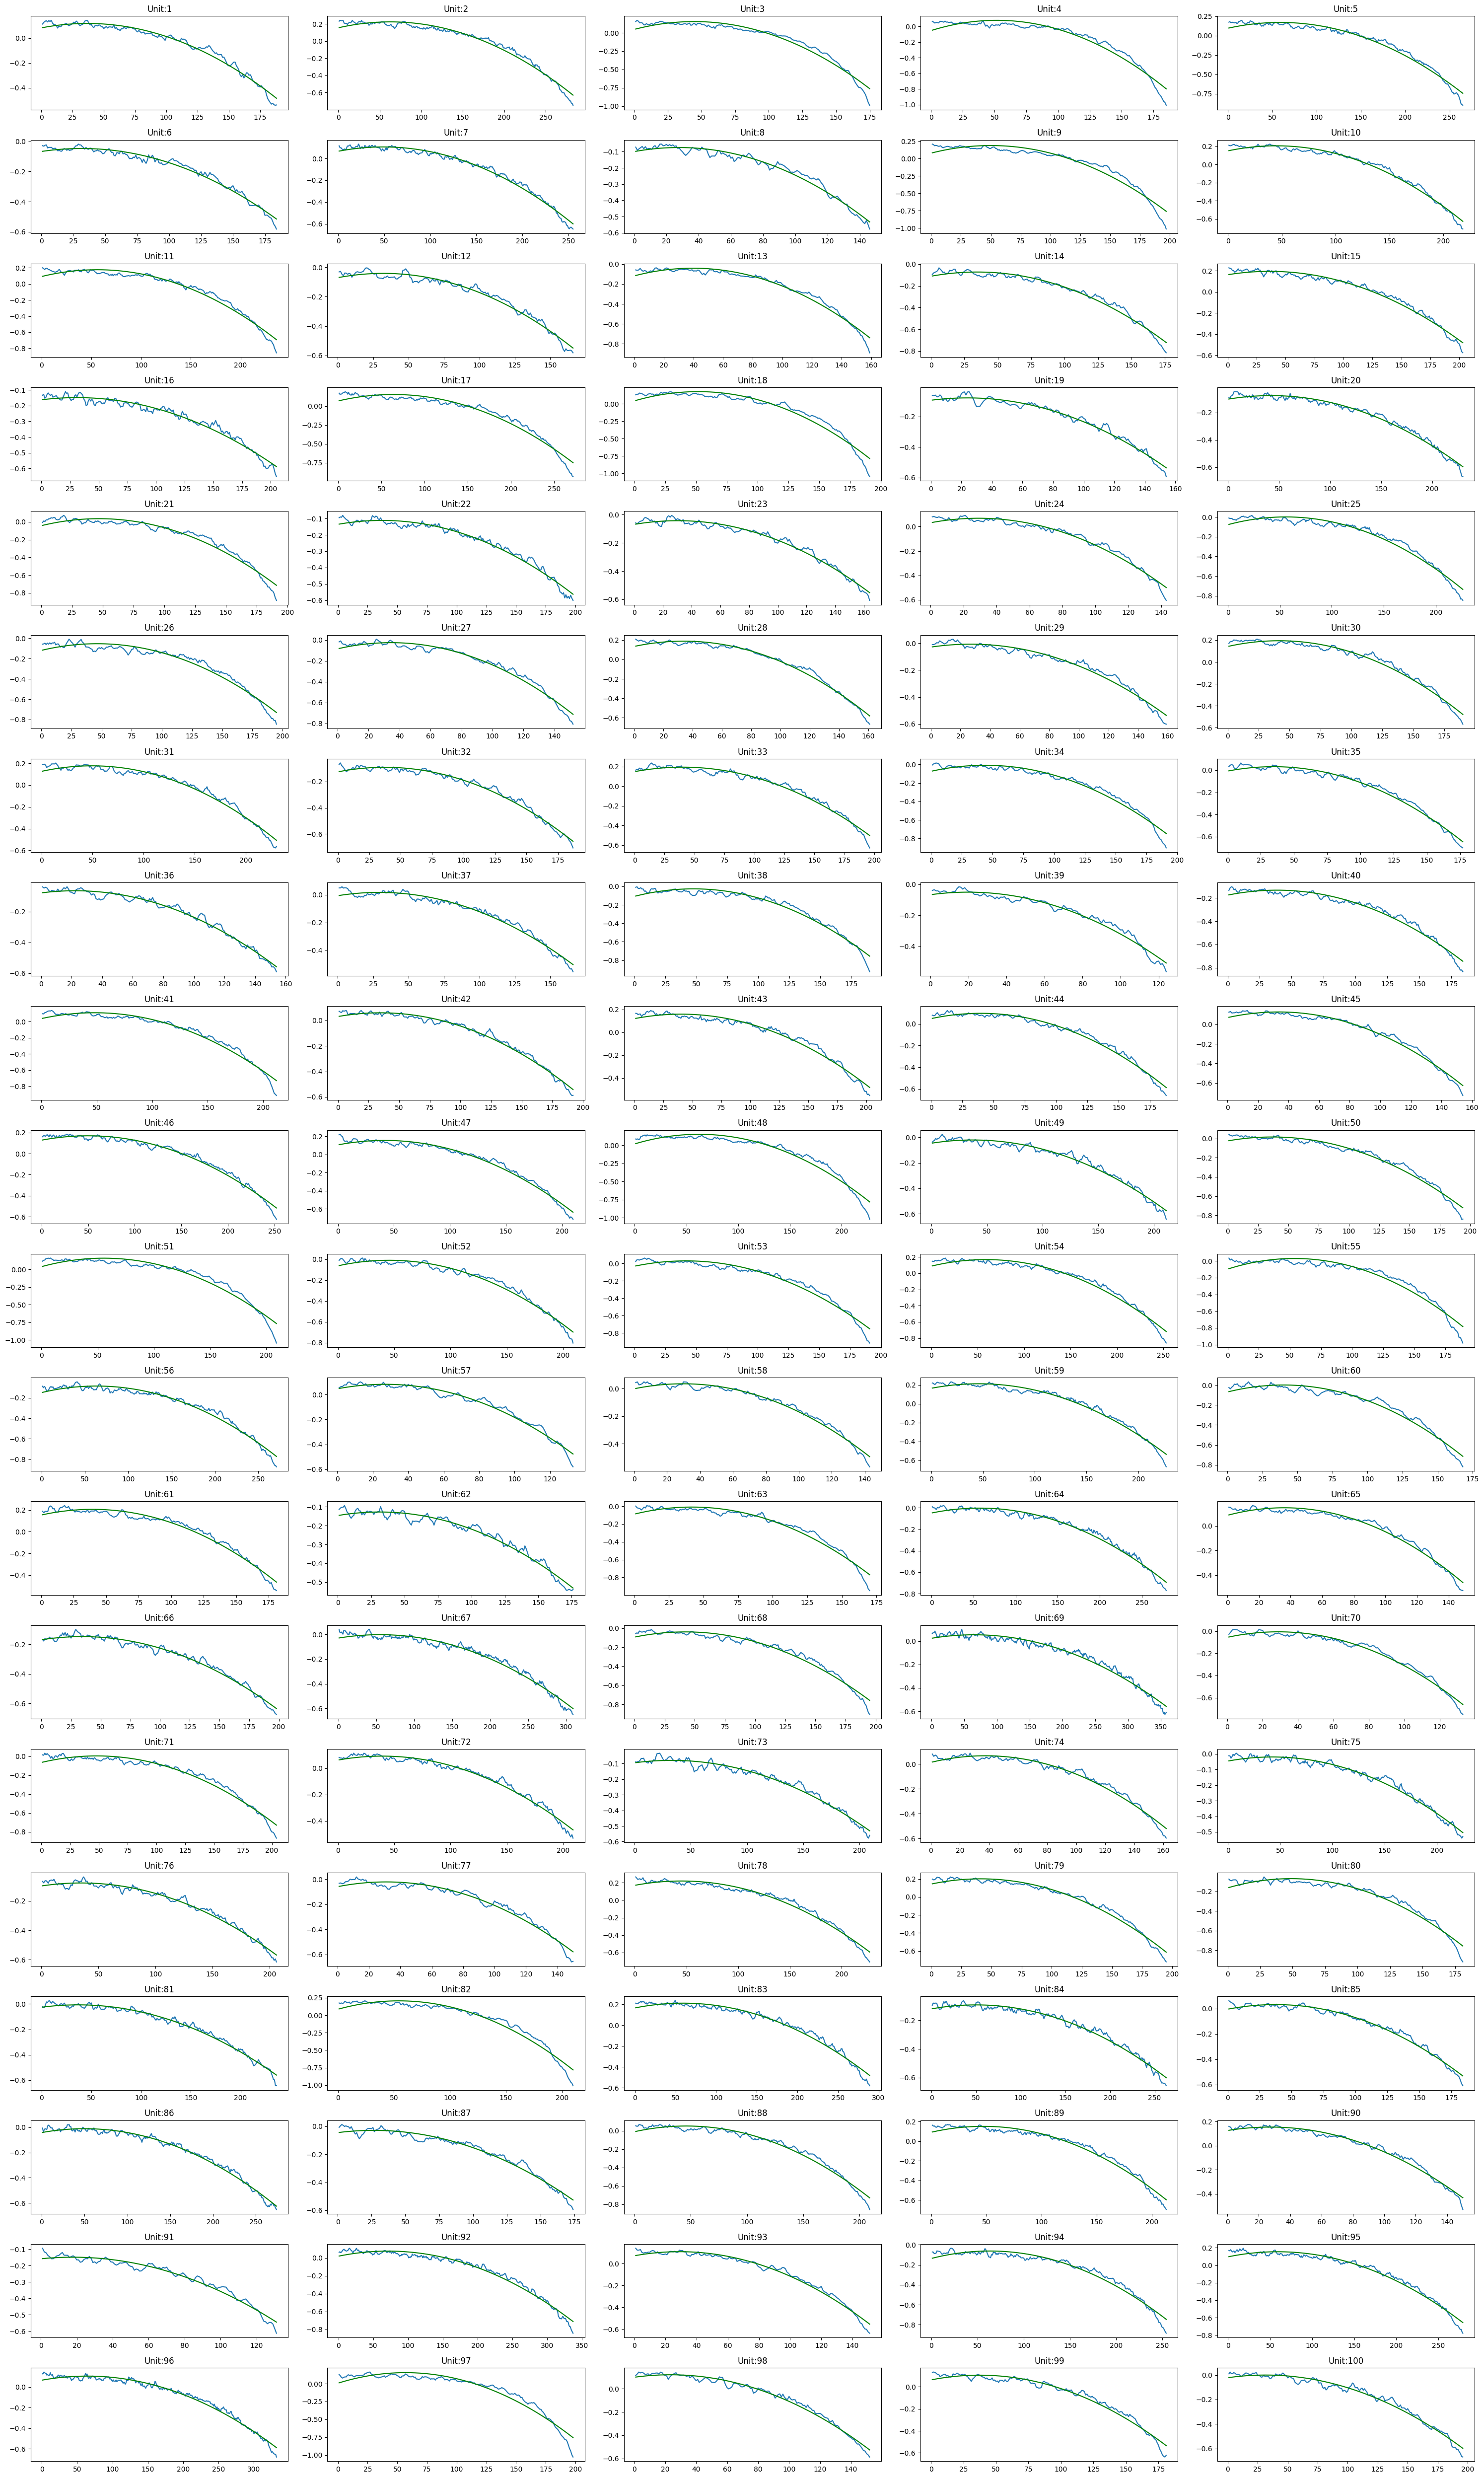

In [ ]:
fig, ax = plt.subplots(nrows = 20, ncols = 5, figsize = (30,50))

ax = ax.ravel()

for i in range(0,100):
    
    theta_0 = params_df.theta_0[params_df.UnitNumber == i+1].values
    theta_1 = params_df.theta_1[params_df.UnitNumber == i+1].values
    theta_2 = params_df.theta_2[params_df.UnitNumber == i+1].values
    
    cycle = df_train_HI.cycle[df_train_HI.UnitNumber == i+1]
    fit_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle
    
    sns.lineplot(data = df_train_HI[df_train_HI.UnitNumber == i+1], x = "cycle", y = "HI_final", ax = ax[i])
    sns.lineplot(y = fit_HI, x = cycle, ax = ax[i], color = "green")
    ax[i].set_title("Unit:" + str(i+1))
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.tight_layout()

### Building a similartiy based RUL model

Steps:

1. Generate a health indicator by multipying weights to selected features in test data
2. Take a rolling mean of Health Indicator to reduce noise
3. Compare the fitted polynomial models with health indicators of test data and find 1-norm residuals using below equation

    $$ d(i,j) = ||y_j - \hat{y_{j,i}} ||_1 $$
    
4. Find similarity score using following formula

    $$ score(i,j) = exp(-d(i,j)^2) $$
   
5. Find top 50 most similar models
6. Find RUL by subtracting current cycle from total cycles of most similar units

#### Step 1

In [ ]:
df_test['HI'] = df_test[feats].dot(model.coef_)
df_test.HI.head()

0    0.095656
1    0.128882
2    0.051068
3    0.087381
4    0.148141
Name: HI, dtype: float64

#### Step 2

In [ ]:
df_test_HI = df_test.groupby('UnitNumber')['HI'].rolling(window = window).mean()
df_test_HI = df_test_HI.reset_index()
df_test_HI.dropna(inplace = True)
df_test_HI.drop(['level_1'], axis = 1, inplace = True)
df_test_HI['cycle'] = df_test_HI.groupby('UnitNumber').cumcount()+1
df_test_HI.head()

UnitNumber        HI  cycle
4           1  0.102226      1
5           1  0.110121      2
6           1  0.103964      3
7           1  0.114302      4
8           1  0.115011      5

#### Step 3 and Step 4

In [ ]:
df_test_fit = pd.DataFrame(columns = ['UnitNumber', 'Model', 'Residual', 'similarity', 'total_life'])

for i in df_test_HI.UnitNumber.unique():
    
    HI = df_test_HI.HI[df_test_HI.UnitNumber == i]
    cycle = df_test_HI.cycle[df_test_HI.UnitNumber == i]
        
    for j in params_df.UnitNumber.unique():
        
        theta_0 = params_df.theta_0[params_df.UnitNumber == j].values
        theta_1 = params_df.theta_1[params_df.UnitNumber == j].values
        theta_2 = params_df.theta_2[params_df.UnitNumber == j].values
        
        pred_HI = theta_0 + theta_1*cycle + theta_2*cycle*cycle
        
        Residual = np.mean(np.abs(pred_HI - HI))

        total_life = df_train.Cycle[df_train.UnitNumber == j].max()
        
        similarity_score = np.exp(-Residual*Residual)
        
        df_test_fit = df_test_fit.append({'UnitNumber':i, 'Model': j, 'Residual': Residual, 
                                          'similarity': similarity_score, 'total_life': total_life},
                                         ignore_index = True)


In [ ]:
df_test_fit.head(20)

UnitNumber  Model  Residual  similarity  total_life
0          1.0    1.0  0.018282    0.999666       192.0
1          1.0    2.0  0.072895    0.994700       287.0
2          1.0    3.0  0.031416    0.999014       179.0
3          1.0    4.0  0.104821    0.989073       189.0
4          1.0    5.0  0.024883    0.999381       269.0
5          1.0    6.0  0.164311    0.973363       188.0
6          1.0    7.0  0.026745    0.999285       259.0
7          1.0    8.0  0.192184    0.963739       150.0
8          1.0    9.0  0.033260    0.998894       201.0
9          1.0   10.0  0.067730    0.995423       222.0
10         1.0   11.0  0.027326    0.999254       240.0
11         1.0   12.0  0.161666    0.974203       170.0
12         1.0   13.0  0.186339    0.965874       163.0
13         1.0   14.0  0.198227    0.961468       180.0
14         1.0   15.0  0.072432    0.994767       207.0
15         1.0   16.0  0.263721    0.932815       209.0
16         1.0   17.0  0.023789    0.999434       276.0
17         1.0   18.0  0.034450    0.998814       195.0
18         1.0   19.0  0.192586    0.963590       158.0
19         1.0   20.0  0.197110    0.961893       234.0

#### Step 5 and 6

*Selecting 5 most similar units*

In [ ]:
ind_50 = df_test_fit.groupby('UnitNumber')['similarity'].nlargest(50).reset_index()['level_1']
result_df_50 = df_test_fit.iloc[ind_50]
result_df_50.head()

UnitNumber  Model  Residual  similarity  total_life
97         1.0   98.0  0.014982    0.999776       156.0
0          1.0    1.0  0.018282    0.999666       192.0
92         1.0   93.0  0.020012    0.999600       155.0
94         1.0   95.0  0.020760    0.999569       283.0
88         1.0   89.0  0.022995    0.999471       217.0

In [ ]:
len(result_df_50)

5000

####Visualizing 5 most similar units to unit 5 of test data

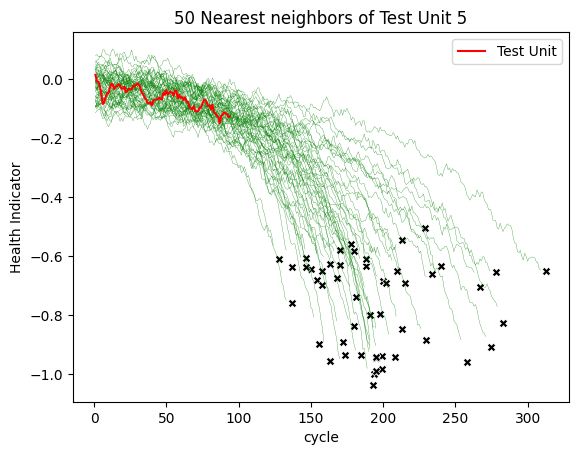

In [ ]:
dff = result_df_50[result_df_50.UnitNumber == 5]
TopRULs_df = pd.DataFrame(columns = ['predicted_Ruls'])
topruls=[]
for i in dff.Model.unique():
    sns.lineplot(data= df_train_HI[df_train_HI.UnitNumber == i], x = 'cycle', y = 'HI_final', color = 'green', lw = 0.2)
    sns.scatterplot(data = df_train[(df_train_HI.UnitNumber == i) & (df_train.HI == 0)], x = 'Cycle', y = 'HI_final', 
                    marker = 'X', color = 'black')
    preRul=int(df_train[(df_train_HI.UnitNumber == i) & (df_train.HI == 0)].Cycle)
    topruls.append(preRul)

TopRULs_df['predicted_Ruls']=topruls
sns.lineplot(data= df_test_HI[df_test_HI.UnitNumber == 5], x = 'cycle', y = 'HI', color = 'red', 
             label = 'Test Unit')
plt.ylabel('Health Indicator')
plt.title('50 Nearest neighbors of Test Unit 5');

Number of samples in our data:  50


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


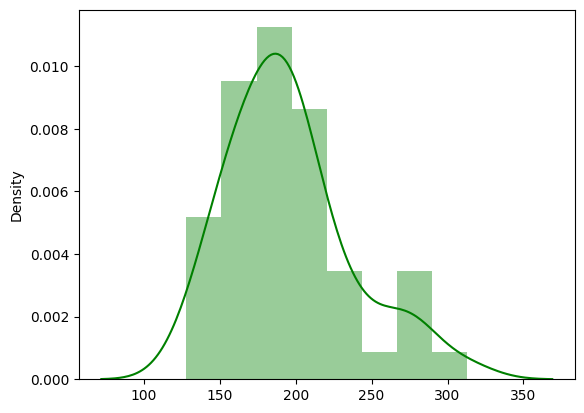

In [ ]:
data = np.array(TopRULs_df['predicted_Ruls'].values)
print("Number of samples in our data: ",data.shape[0])
sns.distplot(data, color='g')
plt.show()
# population mean
population_mean = np.round(data.mean(),3)
# population std
population_std = np.round(data.std(),3)

In [ ]:
def get_means_of_n_samples_with_m_size(data, n, m):
    sample_mean_m_samples_n_ele = []
    data=np.array(data)
    for i in range(0,n):
        samples = random.sample(range(0, data.shape[0]), m)
        sample_mean_m_samples_n_ele.append(data[samples].mean())
    return sample_mean_m_samples_n_ele
def central_limit_theorem(data, population_mean , i, j, color, key):

    sns.distplot(np.array(data), color=color, ax=axs[i, j])
    axs[i, j].axvline(population_mean, linestyle="--", color='r', label="p_mean")
    axs[i, j].axvline(np.array(data).mean(), linestyle="-.", color='b', label="s_mean")
    axs[i, j].set_title(key)
    axs[i, j].legend()

In [ ]:
sample_means = dict()
sample_means['100samples_5ele'] = get_means_of_n_samples_with_m_size(data,100, 5)
sample_means['100samples_10ele'] = get_means_of_n_samples_with_m_size(data,100, 10)
sample_means['100samples_30ele'] = get_means_of_n_samples_with_m_size(data,100, 30)
sample_means['1000samples_30ele'] = get_means_of_n_samples_with_m_size(data,1000, 30)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

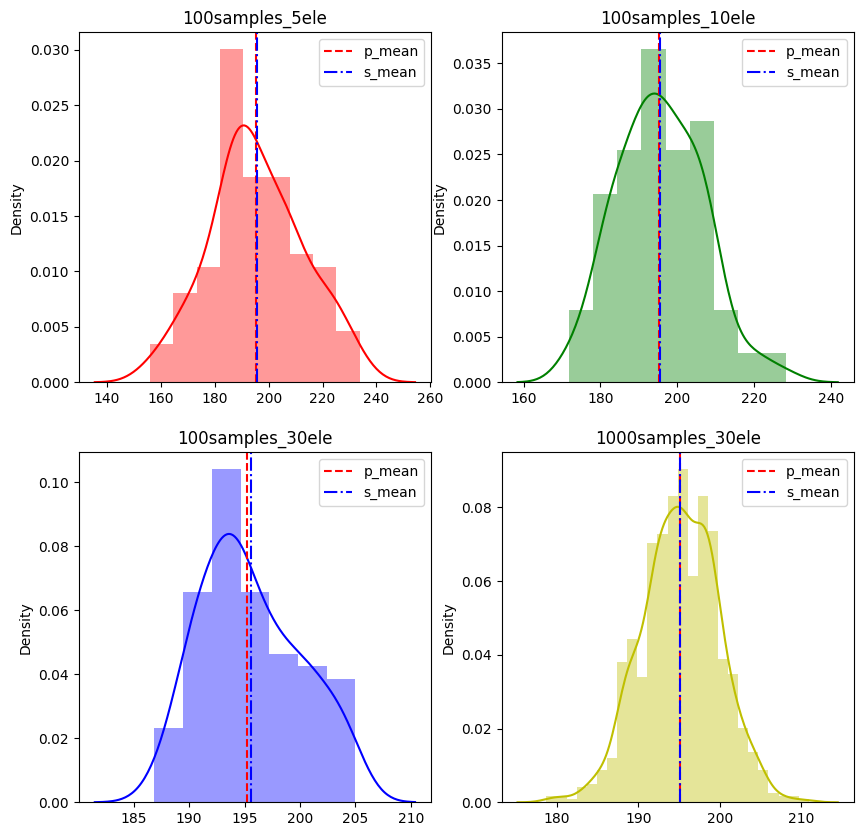

In [ ]:
#red, green, blue, yellow, etc
colrs = ['r','g','b','y', 'c', 'm', 'k']
plt_grid  = [(0,0), (0, 1),(1,0),(1,1)]
sample_sizes = [(100,5), (100, 10),(100,30),(1000,30)]

fig, axs = plt.subplots(2, 2,  figsize=(10, 10))
for i, key in enumerate(sample_means.keys()):
    central_limit_theorem(sample_means[key], population_mean , plt_grid[i][0], plt_grid[i][1] , colrs[i], key)
plt.show()

In [ ]:
x = PrettyTable()
x = PrettyTable(["#samples_name", "P_Mean", "Sampel mean", "P_Std", "Sample Std", "mu_x"+u"\u2248"+"mu", "std_x"+u"\u2248"+"std/"+u"\u221A"+"n"])

for i, key in enumerate(sample_means.keys()):
    sample_mean = np.round(np.array(sample_means[key]).mean(), 3)
    sample_std = np.round(np.array(sample_means[key]).std(), 3)
    population_std_est = np.round(population_std/np.sqrt(sample_sizes[i][1]), 3)
    
    row = []
    row.append(key)
    row.append(population_mean)
    row.append(sample_mean)
    row.append(population_std)
    row.append(sample_std)
    row.append(str(sample_mean)+u"\u2248"+str(population_mean))
    row.append(str(sample_std)+u"\u2248"+str(population_std_est))
    x.add_row(row)
print(x)

+-------------------+--------+-------------+--------+------------+----------------+---------------+
|   #samples_name   | P_Mean | Sampel mean | P_Std  | Sample Std |    mu_x≈mu     |  std_x≈std/√n |
+-------------------+--------+-------------+--------+------------+----------------+---------------+
|  100samples_5ele  | 195.18 |   195.548   | 40.382 |   17.107   | 195.548≈195.18 | 17.107≈18.059 |
|  100samples_10ele | 195.18 |   195.574   | 40.382 |   11.177   | 195.574≈195.18 |  11.177≈12.77 |
|  100samples_30ele | 195.18 |   195.577   | 40.382 |   4.477    | 195.577≈195.18 |  4.477≈7.373  |
| 1000samples_30ele | 195.18 |   195.167   | 40.382 |   4.703    | 195.167≈195.18 |  4.703≈7.373  |
+-------------------+--------+-------------+--------+------------+----------------+---------------+


In [ ]:
data_male = data
samples = random.sample(range(0, data_male.shape[0]), 10)
print("the mean of money spent by sample set of 10 persons :",data_male[samples].mean())
print("Given that the we have population standard deviation : 40.382")

print("From central limit theorem we can say that, the std of sampling distribution of the sample mean is \u03C3/\u221An :", 40.382/10)

the mean of money spent by sample set of 10 persons : 193.6
Given that the we have population standard deviation : 40.382
From central limit theorem we can say that, the std of sampling distribution of the sample mean is σ/√n : 4.0382


In [ ]:
def plt_confidence_interval(data, sample_mean, population_std, i, j, color):
    sns.distplot(data, color=color, ax=axs[i, j])
    axs[i, j].axvline(data.mean(), linestyle="-", color='k', label="p_mean")
    axs[i, j].axvline(sample_mean, linestyle="--", color='m', label="s_mean")
    axs[i, j].axvline(sample_mean+2*(population_std/np.sqrt(30)), linestyle=":", color='g', label="s_mean+2*SE")
    axs[i, j].axvline(sample_mean-2*(population_std/np.sqrt(30)), linestyle=":", color='g', label="s_mean-2*SE")
    axs[i, j].legend()


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

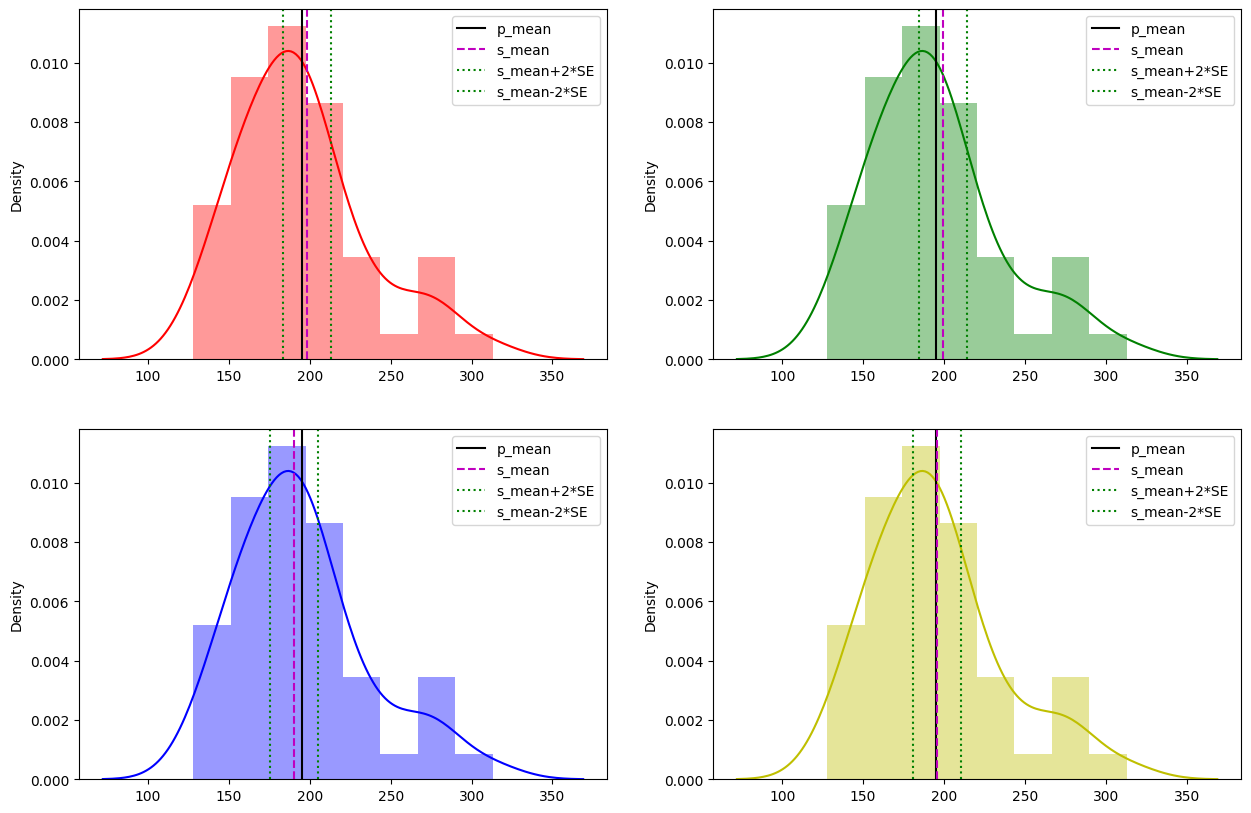

In [ ]:
fig, axs = plt.subplots(2, 2,  figsize=(15, 10))
for i in range(4):
    sample = data_male[random.sample(range(0, data_male.shape[0]), 30)]
    plt_confidence_interval(data_male, np.array(sample).mean(), population_std, plt_grid[i][0],plt_grid[i][1],colrs[i])
plt.show()

In [ ]:
x = PrettyTable()
x = PrettyTable(["#samples", "Sample Size", "Sample mean", "Pop Std","Left C.I","Right C.I","Pop mean","Catch"])
male_population_std = data_male.std()
male_population_mean= np.round(data_male.mean(), 3)
for i in range(10):
    sample=data_male[random.sample(range(0, data_male.shape[0]), 30)]
    sample_mean = sample.mean()
    sample_size = len(sample)
    left_limit  = np.round(sample_mean - 2*(male_population_std/np.sqrt(sample_size)), 3)
    right_limit = np.round(sample_mean + 2*(male_population_std/np.sqrt(sample_size)), 3)
    row = []
    row.append(i+1)
    row.append(sample_size)
    row.append(sample_mean)
    row.append(population_std)
    row.append(left_limit)
    row.append(right_limit)
    row.append(male_population_mean)
    row.append((male_population_mean <= right_limit) and (male_population_mean >= left_limit))
    x.add_row(row)
print(x)

+----------+-------------+--------------------+---------+----------+-----------+----------+-------+
| #samples | Sample Size |    Sample mean     | Pop Std | Left C.I | Right C.I | Pop mean | Catch |
+----------+-------------+--------------------+---------+----------+-----------+----------+-------+
|    1     |      30     | 189.16666666666666 |  40.382 | 174.421  |  203.912  |  195.18  |  True |
|    2     |      30     |       203.4        |  40.382 | 188.655  |  218.145  |  195.18  |  True |
|    3     |      30     |       192.5        |  40.382 | 177.755  |  207.245  |  195.18  |  True |
|    4     |      30     | 202.23333333333332 |  40.382 | 187.488  |  216.979  |  195.18  |  True |
|    5     |      30     | 196.23333333333332 |  40.382 | 181.488  |  210.979  |  195.18  |  True |
|    6     |      30     | 194.73333333333332 |  40.382 | 179.988  |  209.479  |  195.18  |  True |
|    7     |      30     | 189.93333333333334 |  40.382 | 175.188  |  204.679  |  195.18  |  True |


####Step 7

In [ ]:
TopRULs_df = pd.DataFrame(columns = ["UnitNumber","Model",'predicted_Ruls'])
for unit in result_df_50.UnitNumber.unique():
  dff = result_df_50[result_df_50.UnitNumber == unit]
  maxval=df_test.Cycle[df_test.UnitNumber == unit].max()
  for i in dff.Model.unique():
      preRul=int(df_train[(df_train_HI.UnitNumber == i) & (df_train.HI == 0)].Cycle)
      df_train.Cycle[df_train.UnitNumber == j].max()
      TopRULs_df = TopRULs_df.append({"UnitNumber":unit,"Model":i,"predicted_Ruls":preRul},
                                          ignore_index = True)

In [ ]:
TopRULs_df.tail()

In [ ]:
FinalOutPutTestDF = pd.DataFrame(columns = ["std",'p_mean','s_mean'])


In [ ]:
FinalOutPutTestDF["p_mean"] = TopRULs_df.groupby('UnitNumber')['predicted_Ruls'].mean()
FinalOutPutTestDF["std"] = TopRULs_df.groupby('UnitNumber')['predicted_Ruls'].std()

#FinalOutPutTestDF["UnitNumber"] = TopRULs_df.groupby('UnitNumber')['UnitNumber']

In [ ]:
FinalOutPutTestDF.head()

std  p_mean s_mean
UnitNumber                          
1.0         51.150235  214.98    NaN
2.0         48.662893  202.38    NaN
3.0         35.638371  195.22    NaN
4.0         40.807842  195.84    NaN
5.0         40.791501  195.18    NaN

**Confidence interval when don't have knowldge about population standard deviation**

we know the the cofidenance interval[<font color='red'> $\overline{x}$- 2\*$\frac{\sigma}{\sqrt{n}}$, $\overline{x}$+2\*$\frac{\sigma}{\sqrt{n}}$</font>] when we know the popuplation standard deviation. If you observe here we estimating population mean with sample mean (from above pdf plots, the sample mean is almost close to population mean)

__ <font color='#E91BBC'>Can we do the similar estimation of population stadard deviation using sample stadard deviation?</font> __


SE is used is to make confidence intervals of the unknown population mean. If the sampling distribution is normally distributed, the sample mean, the standard error, and the quantiles of the normal distribution can be used to calculate confidence intervals for the true population mean. 

The following expressions can be used to calculate the upper and lower 95% confidence limits


${\text{Upper 95%  limit}{\displaystyle ={\bar {x}}+{\text{SE}}\times 1.96}}$ <br>
${\text{Lower 95%  limit}{\displaystyle ={\bar {x}}-{\text{SE}}\times 1.96}}$

${\displaystyle {\bar {x}}} $ is equal to the sample mean, an estimation to population mean<br>
$SE$ is equal to the standard error for the sample mean, <br>
$1.96$ is the $0.975$ quantile of the normal distribution <br>

<br>
<font color='brown'> But we have taken 0.975 quantile?</font>

<font color='green'> Answer: as we need the confidence level of 95%, the ${\alpha}$ value will be 0.05, so $\frac{\alpha}{2}=0.025$
As we know <br><br>
$${\text{Upper 95%  limit}{\displaystyle ={\bar {x}}+{\text{SE}}\times z_\frac{\alpha}{2}}} = {\bar{x}}+{\text{SE}} \times z_{0.025}  = {\bar{x}}+{\text{SE}} \times 1.96 $$ <br>
$${\text{Lower 95%  limit}{\displaystyle ={\bar {x}}-{\text{SE}}\times z_\frac{\alpha}{2}}} = {\bar{x}}-{\text{SE}} \times z_{0.025}= {\bar{x}}-{\text{SE}} \times 1.96$$


In [ ]:
def get_means_of_n_samples_with_m_size(data, n, m):
    sample_mean_m_samples_n_ele = []
    data=np.array(data)
    for i in range(0,n):
        samples = list(random.sample(range(0, data.shape[0]), m))
        sample_mean_m_samples_n_ele.append(data[samples].mean())
    sample_mean=np.array(sample_mean_m_samples_n_ele).mean()
    sample_std=np.array(sample_mean_m_samples_n_ele).std()
    left_limit  = np.round(sample_mean - 2*(sample_std/np.sqrt(m)), 3)
    right_limit = np.round(sample_mean + 2*(sample_std/np.sqrt(m)), 3)
    return sample_mean,sample_std,left_limit,right_limit
def central_limit_theorem(data, population_mean , i, j, color, key):

    sns.distplot(np.array(data), color=color, ax=axs[i, j])
    axs[i, j].axvline(population_mean, linestyle="--", color='r', label="p_mean")
    axs[i, j].axvline(np.array(data).mean(), linestyle="-.", color='b', label="s_mean")
    axs[i, j].set_title(key)
    axs[i, j].legend()

In [ ]:
s_meanPerUnit=[]
s_stdPerUnit=[]
Left_CI=[]
Right_CI =[]
for unit in TopRULs_df.UnitNumber.unique():
  s_mean,s_std,left_limit,right_limit=get_means_of_n_samples_with_m_size(TopRULs_df[TopRULs_df.UnitNumber == int(unit)]['predicted_Ruls'],1000, 5)
  s_meanPerUnit.append(s_mean)
  s_stdPerUnit.append(s_std)
  Left_CI.append(left_limit)
  Right_CI.append(right_limit)

FinalOutPutTestDF['s_mean'] = s_meanPerUnit
FinalOutPutTestDF['s_std'] = s_stdPerUnit
FinalOutPutTestDF['Left_CI'] = Left_CI
FinalOutPutTestDF['Right_CI'] = Right_CI

In [ ]:
FinalOutPutTestDF.head()

std  p_mean    s_mean      s_std  Left_CI  Right_CI
UnitNumber                                                           
1.0         51.150235  214.98  214.4234  22.088963  194.666   234.180
2.0         48.662893  202.38  202.5508  21.260997  183.534   221.567
3.0         35.638371  195.22  194.6458  14.960121  181.265   208.027
4.0         40.807842  195.84  195.9136  16.943694  180.759   211.069
5.0         40.791501  195.18  194.2542  18.307915  177.879   210.629

In [ ]:
df_test_HI.head()

UnitNumber        HI  cycle
4           1  0.102226      1
5           1  0.110121      2
6           1  0.103964      3
7           1  0.114302      4
8           1  0.115011      5

In [ ]:
actualCurrentStateOfTestData=[]
for i in df_test_HI.UnitNumber.unique():
  actualCurrentStateOfTestData.append(df_test_HI.cycle[df_test_HI.UnitNumber == i].max())

In [ ]:
y_test['CurrentState']=actualCurrentStateOfTestData
y_test['actualTotalLife']=y_test['CurrentState']+y_test['RUL']

In [ ]:
FinalOutPutTestDF=FinalOutPutTestDF.merge(y_test, on=['UnitNumber'], how='left')

In [ ]:
FinalOutPutTestDF['predicted-RUL_Left']=FinalOutPutTestDF['Left_CI']-y_test['CurrentState']
FinalOutPutTestDF['predicted-RUL_Right']=FinalOutPutTestDF['Right_CI']-y_test['CurrentState']

In [ ]:
FinalOutPutTestDF.head()

UnitNumber        std  p_mean  ...  RUL  CurrentState  actualTotalLife
0         1.0  51.150235  214.98  ...  112            27              139
1         2.0  48.662893  202.38  ...   98            45              143
2         3.0  35.638371  195.22  ...   69           122              191
3         4.0  40.807842  195.84  ...   82           102              184
4         5.0  40.791501  195.18  ...   91            94              185

[5 rows x 12 columns]

In [ ]:
FinalOutPutTestDF[['predicted-RUL_Left','predicted-RUL_Right','RUL']]

predicted-RUL_Left  predicted-RUL_Right  RUL
0              167.666              207.180  112
1              138.534              176.567   98
2               59.265               86.027   69
3               78.759              109.069   82
4               83.879              116.629   91
..                 ...                  ...  ...
95             103.963              141.721  137
96              71.554              109.501   82
97              63.367               93.149   59
98             104.570              141.945  117
99              22.351               55.635   20

[100 rows x 3 columns]

### Results

Text(0, 0.5, 'True RUL')

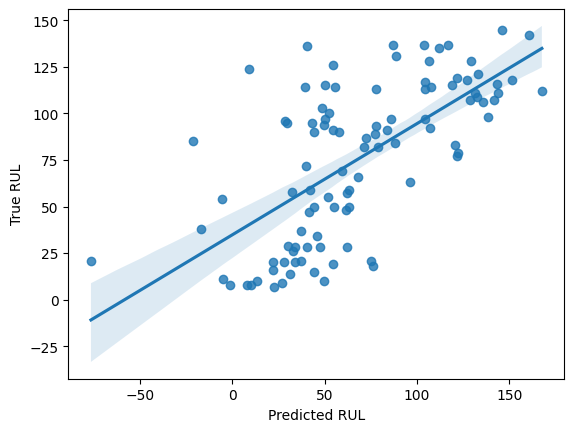

In [ ]:
sns.regplot(x = FinalOutPutTestDF['predicted-RUL_Left'], y = FinalOutPutTestDF['RUL'])
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

Text(0, 0.5, 'True RUL')

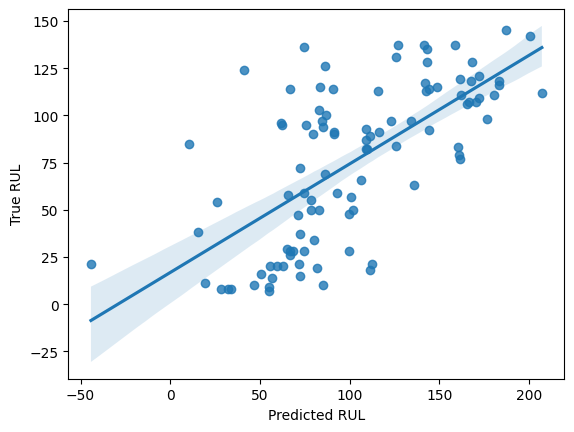

In [ ]:
sns.regplot(x = FinalOutPutTestDF['predicted-RUL_Right'], y = FinalOutPutTestDF['RUL'])
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

Text(0, 0.5, 'True RUL')

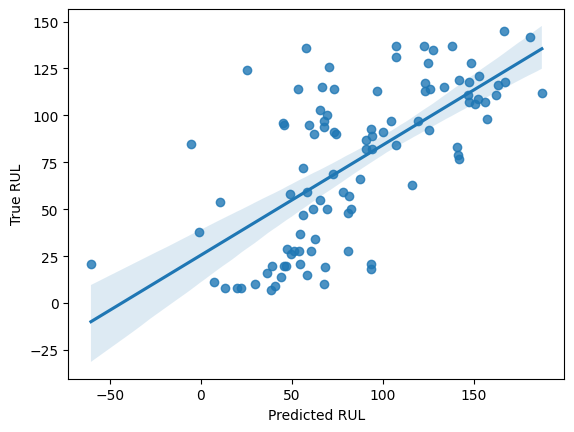

In [ ]:
sns.regplot(x = FinalOutPutTestDF['s_mean']-FinalOutPutTestDF['CurrentState'], y = FinalOutPutTestDF['RUL'])
plt.xlabel('Predicted RUL')
plt.ylabel('True RUL')

In [ ]:
count=0
for unit in FinalOutPutTestDF.UnitNumber.values:
  lowerPred_RUL=FinalOutPutTestDF['predicted-RUL_Left'][unit-1]
  UpperPred_RUL=FinalOutPutTestDF['predicted-RUL_Right'][unit-1]
  True_RUL=FinalOutPutTestDF['RUL'][unit-1]
  if lowerPred_RUL<True_RUL<UpperPred_RUL:
    count=count+1
print("error %   :",count)

error %   : 27


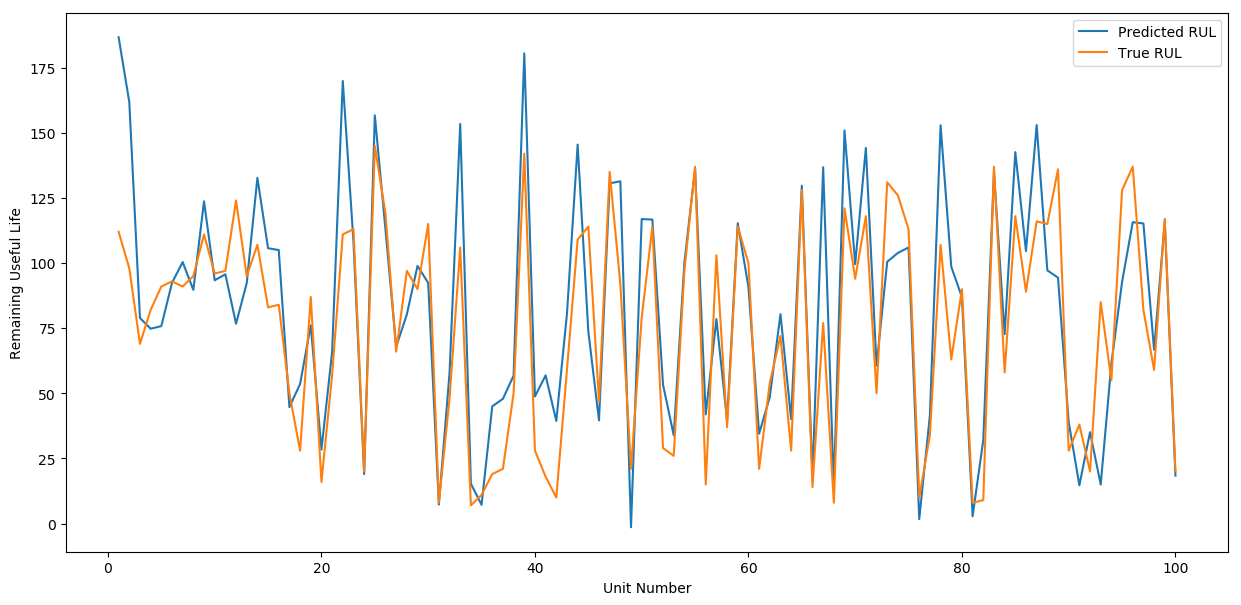

In [ ]:
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(x = y_true_50.UnitNumber, y = y_true_50.Pred_RUL, label = "Predicted RUL")
sns.lineplot(x = y_true_50.UnitNumber, y = y_true_50.RUL, label = "True RUL")
plt.xlabel("Unit Number")
plt.ylabel("Remaining Useful Life")
plt.legend(loc = 1)

### Errors

In [ ]:
mean_squared_error(y_true_5.RUL, y_true_5.Pred_RUL)

530.5268000000001

In [ ]:
mean_absolute_error(y_true_5.RUL, y_true_5.Pred_RUL)

16.81

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true_5.RUL, y_true_5.Pred_RUL)

34.76065468809448